# Detecção de Anomalias

$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bU}{\mathbf{U}}$
$\newcommand{\bu}{\mathbf{u}}$
$\newcommand{\bV}{\mathbf{V}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bG}{\mathbf{G}}$
$\newcommand{\bg}{\mathbf{g}}$
$\newcommand{\bZ}{\mathbf{Z}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$
$\newcommand{\bC}{\mathbf{C}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\calS}{\mathcal{S}}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from urllib.request import urlretrieve
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.covariance import EmpiricalCovariance, MinCovDet, EllipticEnvelope

def gen_data(clean=True):
    from sklearn.datasets import make_blobs
    from sklearn.utils import shuffle
    rot = lambda a: np.array([[np.cos(a), np.sin(a)], [np.sin(-a), np.cos(a)]])
    m0, m1 = (300, 10)
    X0 = make_blobs(n_samples=2*m0, n_features=2, centers=[[0, 0]], cluster_std=0.8, random_state=0)[0]
    X1 = make_blobs(n_samples=2*m1, n_features=2, centers=[[0, 0]], cluster_std=4, random_state=3)[0]
    X0 = [15, 15] + X0 @ np.diag((2.5,1)) @ rot(np.pi*60/180)
    X1 = [15, 15] + X1 @ np.diag((2.5,1)) @ rot(-np.pi*60/180)
    X1 = shuffle(X1, random_state=3)
    X = np.r_[X0[:m0], X1[:m1], X0[m0:], X1[m1:]]
    X_train = shuffle(X[:m0 if clean else m0+m1], random_state=0)
    X_val, y_val = shuffle(X[m0+m1:], np.r_[np.zeros(m0), np.ones(m1)], random_state=1)
    return X_train, X_val, y_val

def plot_data(X, y_true=None, y_pred=None, *, mean=None, cov=None):
    plt.scatter(X[:,0], X[:,1], marker='x')
    plt.axis('square')
    plt.axis([0, 30, 0, 30])
    # mark anomalies
    if y_true is not None:
        y_true = y_true > 0
        plt.scatter(X[y_true,0], X[y_true,1], c='red', marker='x', s=50)
    # mark predictions
    if y_pred is not None:
        y_pred = y_pred > 0
        plt.scatter(X[y_pred,0], X[y_pred,1], c='none', marker='o', edgecolors='black', linewidths=2, s=100)
    # plot level curves corresponding to p = 10^-3, 10^-6, 10^-9, ...
    if mean is not None and cov is not None:
        X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
        XX = np.c_[X1.reshape(-1), X2.reshape(-1)]
        p = multivariate_normal(mean=mean, cov=cov).pdf(XX)
        p = p.reshape(X1.shape)
        plt.contour(X1, X2, -np.log10(p + np.finfo(np.float64).tiny), 
                    levels=3*np.arange(1, 16), cmap='Greens_r', zorder=-1)
    return

def max_f1_score(y_true, y_score):
    # slow implementation; don't use for large datasets
    ts = np.unique(y_score)
    ts = (np.r_[2*ts[0]-ts[1], ts] + np.r_[ts, 2*ts[-1]-ts[-2]])/2
    f1s = np.zeros(len(ts))
    best = 0
    for i, t in enumerate(ts):
        y_pred = y_score > t
        f1s[i] = f1_score(y_true, y_pred)
        if f1s[i] > f1s[best]:
            best = i
    return f1s[best], ts[best]

# Detecção de novidades

- **Aprendizado semi-supervisionado:** conjunto de treinamento "limpo", composto somente por amostras normais
- Dispomos também de um conjunto de validação rotulado, com amostras normais e anômalas
- Rótulo 0 indica um amostra normal e rótulo 1 indica uma anomalia
- Nosso foco será em modelos gaussianos

Train shape: (300, 2)
 Val shapes: (310, 2) (310,)


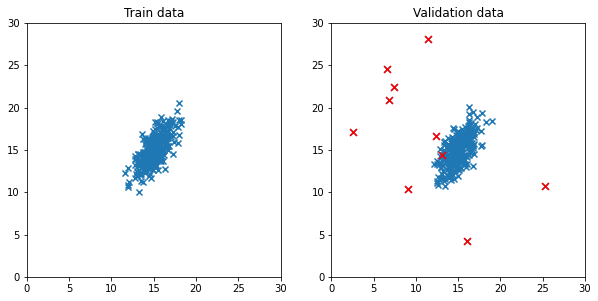

In [2]:
X_train, X_val, y_val = gen_data(clean=True)
print('Train shape:', X_train.shape)
print(' Val shapes:', X_val.shape, y_val.shape)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Train data')
plot_data(X_train)
plt.subplot(1, 2, 2)
plt.title('Validation data')
plot_data(X_val, y_val)

## Implementação própria

Em um modelo gaussiano multivariável, a densidade de probabilidade de uma amostra $\bx$ é calculada como

$$p(\bx) = \frac{1}{\sqrt{\det(2\pi\bC)}} \exp\left(-\frac{1}{2}(\bx-\bmu)^T \bC^{-1} (\bx-\bmu)\right)$$

onde $\bmu$ é o vetor de médias e $\bC$ é a matriz de covariância. Treinar o modelo corresponde a estimar $\bmu$ e $\bC$.

- Obs: `np.var` e `np.cov` utilizam valores padrão diferentes do parâmetro `ddof`: respectivamente, 0 (estimativa [enviesada](https://en.wikipedia.org/wiki/Variance#Biased_sample_variance)) e 1 ([não-enviesada](https://en.wikipedia.org/wiki/Variance#Unbiased_sample_variance)).

In [3]:
mean = X_train.mean(axis=0)
cov = np.cov(X_train, rowvar=False, ddof=0)
var = X_train.var(axis=0)

print('mean:')
print(mean)
print('cov:')
print(cov)
print('var:')
print(var)

mean:
[15.02787068 14.96522391]
cov:
[[1.46108285 1.49557774]
 [1.49557774 3.08972968]]
var:
[1.46108285 3.08972968]


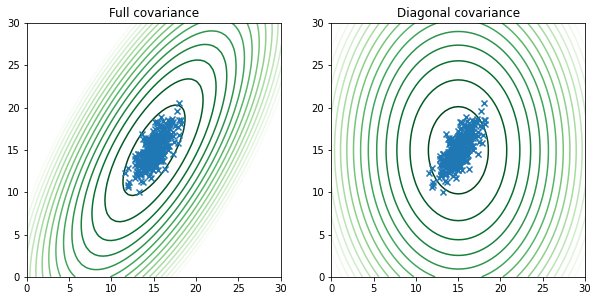

In [4]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Full covariance')
plot_data(X_train, mean=mean, cov=cov)
plt.subplot(1, 2, 2)
plt.title('Diagonal covariance')
#plot_data(X_train, mean=mean, cov=np.diag(var))
plot_data(X_train, mean=mean, cov=var)

Para realizar a detecção de anomalias, é necessário definir um limiar $\epsilon$ de tal forma que uma amostra $\bx$ seja classificada como anômala quando $p(\bx) < \epsilon$. Não há um valor correto ou uma forma única de escolher este limiar: trata-se de uma escolha arbitrária que depende do nível de precisão (*precision*) ou revocação (*recall*) desejado. Mesmo para um nível de precisão ou revocação escolhido, o valor específico de $\epsilon$ vai depender do modelo probabilístico utilizado. Uma abordagem comumente utilizada é escolher o limiar que maximiza o [score F1](https://en.wikipedia.org/wiki/Precision_and_recall#F-measure), a média harmônica entre precisão e revocação. Note que, para calcular quaisquer dessas métricas, é necessário dispor de um conjunto de validação rotulado.

- Obs: As curvas de nível da função `plot_data` correspondem a $p = 10^{-3}, 10^{-6}, 10^{-9}, \ldots$

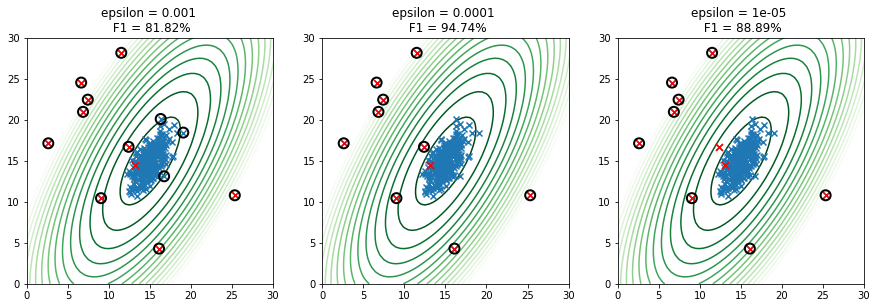

In [5]:
rv = multivariate_normal(mean=mean, cov=cov)

epsilons = [1e-3, 1e-4, 1e-5]
plt.figure(figsize=(15, 15))
for i, epsilon in enumerate(epsilons):
    y_pred = rv.pdf(X_val) < epsilon
    f1 = f1_score(y_val, y_pred)
    plt.subplot(1, len(epsilons), i+1)
    plt.title(f'epsilon = {epsilon:g} \n F1 = {f1:.2%}')
    plot_data(X_val, y_val, y_pred, mean=mean, cov=cov)

## Usando o scikit-learn

Ao invés de usar as funções acima, é mais conveniente usar o objeto `sklearn.covariance.EmpiricalCovariance`, que implementa estimação e inferência de forma integrada. No entanto, não há uma função para cálculo de probabilidade: está implementado apenas o cálculo da [distância de Mahalanobis](https://en.wikipedia.org/wiki/Mahalanobis_distance) ao quadrado (função `.mahalanobis`), correspondente ao termo

$$d^2 = (\bx-\bmu)^T \bC^{-1} (\bx-\bmu)$$

de tal forma que

$$p(\bx) = \frac{1}{\sqrt{\det(2\pi\bC)}} \exp(-d^2/2).$$

Note, porém, que $p(\bx) < \epsilon \iff d^2 > \gamma \triangleq -2\log\left(\epsilon \sqrt{\det(2\pi\bC)}\right)$. Portanto, é matematicamente equivalente realizar a detecção de anomalias através da distância (quadrada) de Mahalanobis, sendo que quanto *maior* esse valor, *maior* a chance de a amostra ser anômala.

In [6]:
from sklearn.covariance import EmpiricalCovariance

model = EmpiricalCovariance().fit(X_train)
print(model.location_)
print(model.covariance_)

[15.02787068 14.96522391]
[[1.46108285 1.49557774]
 [1.49557774 3.08972968]]


In [7]:
d2 = model.mahalanobis(X_train[:3])
d2

array([0.7554789 , 3.39224637, 0.45874519])

In [8]:
1/np.sqrt(np.linalg.det(2*np.pi*cov)) * np.exp(-d2/2)

array([0.07228221, 0.01934036, 0.0838429 ])

In [9]:
rv.pdf(X_train[:3])

array([0.07228221, 0.01934036, 0.0838429 ])

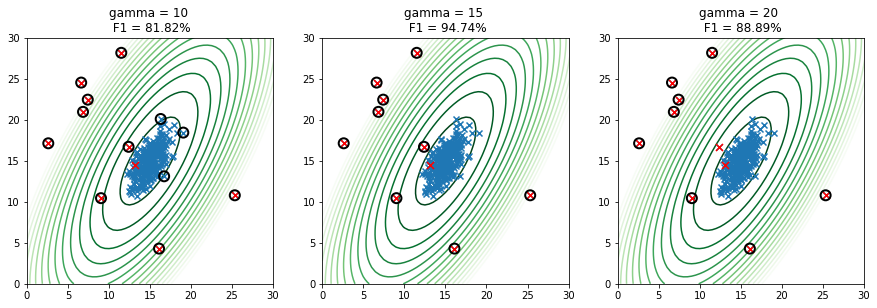

In [10]:
gammas = [10, 15, 20]
plt.figure(figsize=(15, 15))
for i, gamma in enumerate(gammas):
    y_pred = model.mahalanobis(X_val) > gamma
    f1 = f1_score(y_val, y_pred)
    plt.subplot(1, len(gammas), i+1)
    plt.title(f'gamma = {gamma:g} \n F1 = {f1:.2%}')
    plot_data(X_val, y_val, y_pred, mean=model.location_, cov=model.covariance_)

- A função fornecida `max_f1_score(y_true, y_score)` (implementação própria) determina o máximo valor de F1 alcançável no conjunto de validação, onde `y_score` representa um score de confiança de que a amostra é positiva; neste caso, podemos usar diretamente o valor de $d^2$. A função retorna o valor de F1 e o respectivo limiar utilizado para alcançar esse valor.

In [11]:
f1, t = max_f1_score(y_val, model.mahalanobis(X_val))
print(f'Max F1 = {f1:.2%} at threshold {t:g}')

Max F1 = 94.74% at threshold 14.3797


# Detecção de outliers

- **Aprendizado não-supervisionado:** conjunto de treinamento "contaminado" (pode conter amostras anômalas) e **não-rotulado**. 
- Os outliers do conjunto de treinamento podem prejudicar o desempenho se o modelo não for robusto

Train shape: (310, 2)
 Val shapes: (310, 2) (310,)


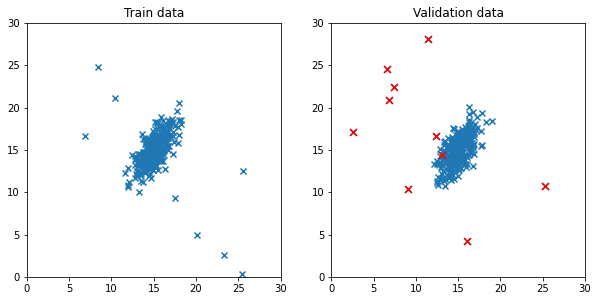

In [12]:
X_train, X_val, y_val = gen_data(clean=False)
print('Train shape:', X_train.shape)
print(' Val shapes:', X_val.shape, y_val.shape)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Train data')
plot_data(X_train)
plt.subplot(1, 2, 2)
plt.title('Validation data')
plot_data(X_val, y_val)

## EmpiricalCovariance

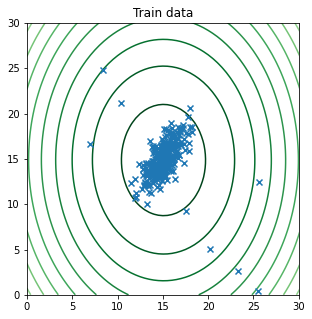

In [13]:
model = EmpiricalCovariance().fit(X_train)
plt.figure(figsize=(5, 5))
plt.title('Train data')
plot_data(X_train, mean=model.location_, cov=model.covariance_)

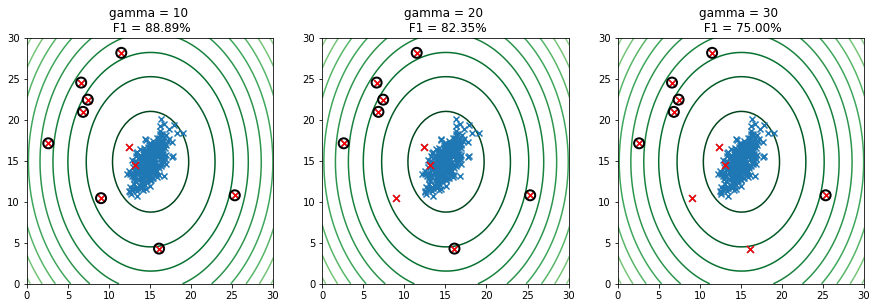

In [14]:
gammas = [10, 20, 30]
plt.figure(figsize=(15, 15))
for i, gamma in enumerate(gammas):
    y_pred = model.mahalanobis(X_val) > gamma
    f1 = f1_score(y_val, y_pred)
    plt.subplot(1, len(gammas), i+1)
    plt.title(f'gamma = {gamma:g} \n F1 = {f1:.2%}')
    plot_data(X_val, y_val, y_pred, mean=model.location_, cov=model.covariance_)

In [15]:
f1, t = max_f1_score(y_val, model.mahalanobis(X_val))
print(f'Max F1 = {f1:.2%} at threshold {t:g}')

Max F1 = 88.89% at threshold 12.2418


## MinCovDet

- O algoritmo `MinCovDet` assume o mesmo modelo gaussiano, porém com uma estimação de covariância robusta a outliers, devido principalmente aos seguintes aspectos:
  - O algoritmo utiliza apenas uma fração `support_fraction` das amostras na estimação inicial da matriz de covariância;
  - A estimação final é feita reponderando as amostras de acordo com sua distância de Mahalanobis, de forma que amostras mais distantes tenham menor impacto na estimação.
- Mesmo em um problema de detecção de novidades (conjunto de treinamento formado só por amostras normais), o algoritmo `MinCovDet` pode apresentar um desempenho superior ao do `EmpiricalCovariance`, devido à sua etapa de reponderação de amostras, caso o conjunto de treinamento possua outliers (nem todo outlier é necessariamente uma anomalia e nem toda anomalia é necessariamente um outlier, para um dado conjunto de atributos). Nesse caso (para detecção de novidades), pode ser útil aumentar o parâmetro `support_fraction` para acelerar o algoritmo.

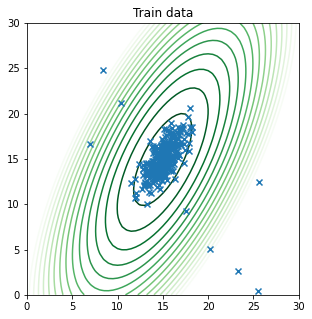

In [16]:
from sklearn.covariance import MinCovDet

model = MinCovDet().fit(X_train)
plt.figure(figsize=(5, 5))
plt.title('Train data')
plot_data(X_train, mean=model.location_, cov=model.covariance_)

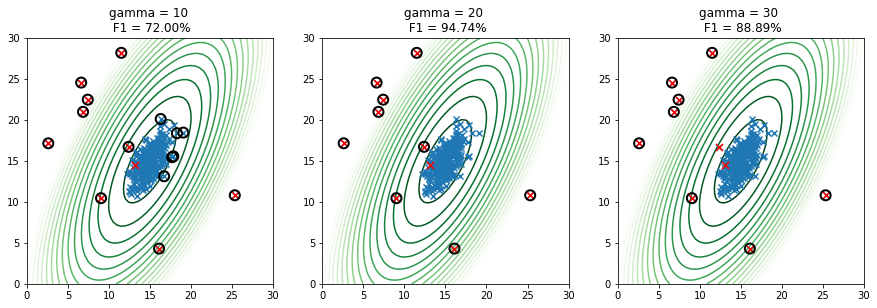

In [17]:
gammas = [10, 20, 30]
plt.figure(figsize=(15, 15))
for i, gamma in enumerate(gammas):
    y_pred = model.mahalanobis(X_val) > gamma
    f1 = f1_score(y_val, y_pred)
    plt.subplot(1, len(gammas), i+1)
    plt.title(f'gamma = {gamma:g} \n F1 = {f1:.2%}')
    plot_data(X_val, y_val, y_pred, mean=model.location_, cov=model.covariance_)

In [18]:
f1, t = max_f1_score(y_val, model.mahalanobis(X_val))
print(f'Max F1 = {f1:.2%} at threshold {t:g}')

Max F1 = 94.74% at threshold 18.167


- Caso um conjunto de validação não esteja disponível, mas seja conhecida a proporção de amostras "contaminadas" no conjunto de treinamento, podemos ainda utilizar o algoritmo `sklearn.covariance.EllipticEnvelope`, o qual internamente utiliza o `MinCovDet`, mas define o limiar de classificação automaticamente de tal forma a obter uma determinada fração de outliers no conjunto de treinamento, dada pelo parâmetro `contamination`. Note que a função `.predict` deste modelo utiliza a codificação -1 para representar uma amostra anômala e 1 para uma amostra normal.

F1 = 78.26%


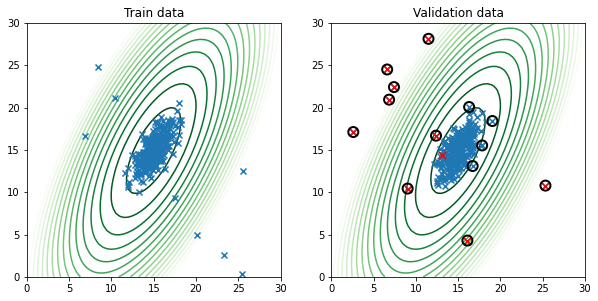

In [19]:
from sklearn.covariance import EllipticEnvelope

model = EllipticEnvelope(contamination=y_val.mean()).fit(X_train)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Train data')
plot_data(X_train, mean=model.location_, cov=model.covariance_)
plt.subplot(1, 2, 2)
plt.title('Validation data')
y_pred = model.predict(X_val) < 0
plot_data(X_val, y_val, y_pred, mean=model.location_, cov=model.covariance_)
f1 = f1_score(y_val, y_pred)
print(f'F1 = {f1:.2%}')

# Exemplo: Detecção de fraudes em transações de cartão de crédito

O próximo conjunto consiste de dados de transações de cartão de crédito, disponível em:

https://www.kaggle.com/mlg-ulb/creditcardfraud

O objetivo é identificar transações fradulentas. O conjunto é formado por 284807 amostras, sendo destas 492 fradulentas, correspondendo a transações realizadas ao longo de 48 horas consecutivas. Os atributos consistem do rótulo da transação ($y=1$ corresponde a uma transação fradulenta) e 30 atributos de entrada, sendo que destes 28 correspondem às componentes principais dos atributos originais, os quais não são fornecidos por uma questão de confidencialidade. (Incidentalmente, este conjunto ilustra mais uma aplicação de PCA: anonimização.)

- Iremos separar 2/3 das amostras normais como conjunto de treinamento e, como conjunto de validação, utilizaremos todas as amostras anômalas e as restantes 1/3 de amostras normais.
- Para avaliação de desempenho do classificador, vamos utilizar inicialmente a métrica [*average precision*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) (`sklearn.metrics.average_precision_score`) sobre o conjunto de validação, a qual pode ser interpretada como a área embaixo da curva *precision-recall*. (Como essa métrica sumariza o desempenho do classificador sobre todos os possíveis limiares, não há necessidade de escolher um limiar; ao invés disso devem ser entregues à função scores de confiança de que a amostra é positiva, como por exemplo a distância de Mahalanobis no caso de um modelo gaussiano ou a saída não-binarizada no caso de um classificador binário convencional.)
- Também utilizaremos como métrica um ponto de operação específico na curva ROC, i.e., taxa de verdadeiro positivo (= *recall*) para um dado valor da taxa de falso positivo.

## Preparação dos dados

In [20]:
%%time
url = 'http://danilosilva.sites.ufsc.br/data/creditcard.csv.gz'
filename = urlretrieve(url, url.split('/', )[-1])[0]
print('Downloaded:', filename)

# Or download from Kaggle

Downloaded: creditcard.csv.gz
Wall time: 16.5 s


In [21]:
df = pd.read_csv(filename)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [22]:
df['Time'].max()/3600

47.99777777777778

In [23]:
X = df.to_numpy()[:, :-1]
y = df.to_numpy()[:, -1]
print(' Full:', X.shape, y.shape, f'{y.mean():.2%}')

X_train, X_val, y_train, y_val = train_test_split(X[y == 0], y[y == 0], test_size=1/3, random_state=2)
X_val = np.r_[X_val, X[y == 1]]
y_val = np.r_[y_val, y[y == 1]]
del X, y

X_train_orig = X_train.copy()
X_val_orig = X_val.copy()

print('Train:', X_train.shape, y_train.shape, f'{y_train.mean():.2%}')
print('  Val:', X_val.shape, y_val.shape, f'{y_val.mean():.2%}')

 Full: (284807, 30) (284807,) 0.17%
Train: (189543, 30) (189543,) 0.00%
  Val: (95264, 30) (95264,) 0.52%


Wall time: 4.31 s


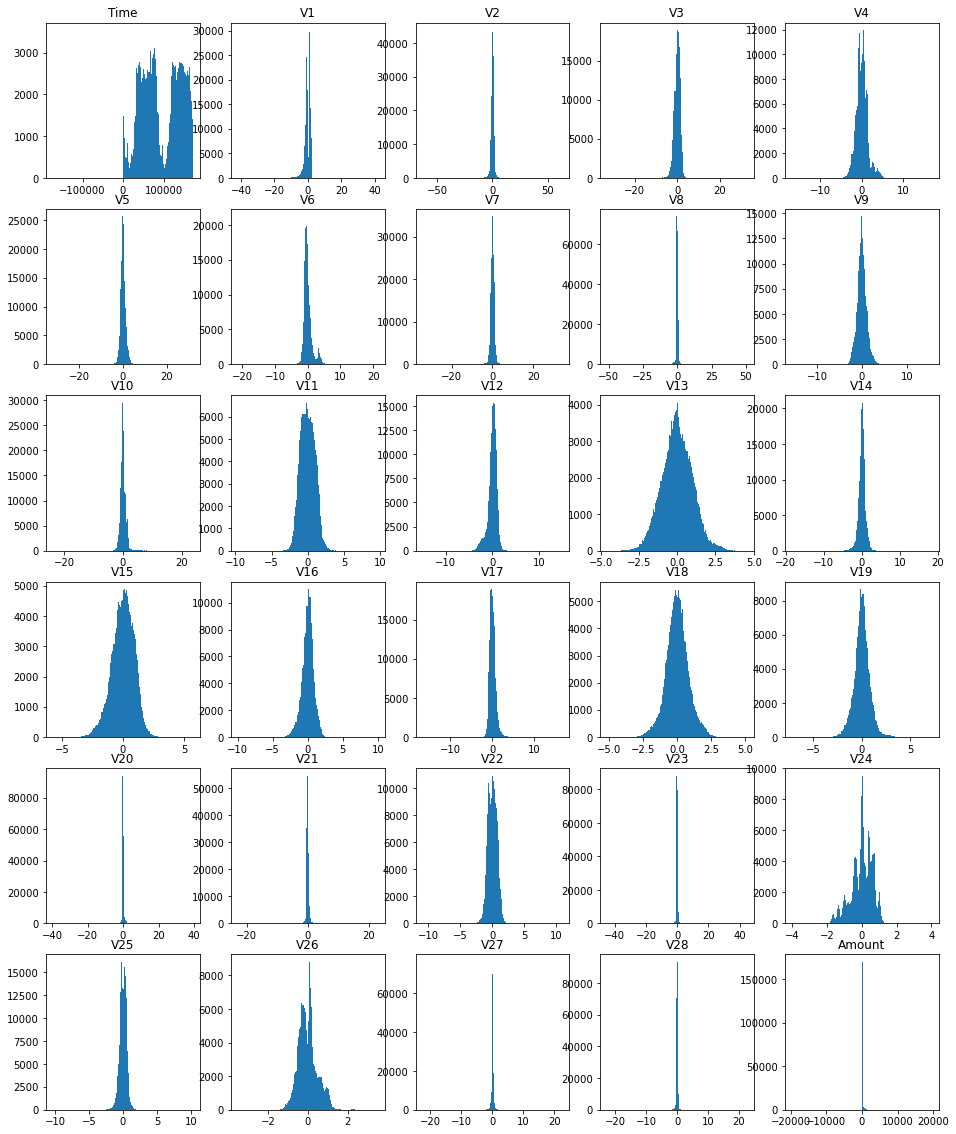

In [24]:
%%time
n_rows, n_cols = (6, 5)
plt.figure(figsize=(16, 20))
for i in range(n_rows):
    for j in range(n_cols):
        k = j + n_cols*i
        plt.subplot(n_rows, n_cols, 1 + k)
        plt.title(df.columns[k])
        a = np.abs(np.percentile(X_train[:,k], [0, 100])).max()
        plt.hist(X_train[:,k], 200, [-a, a]);

Wall time: 4.53 s


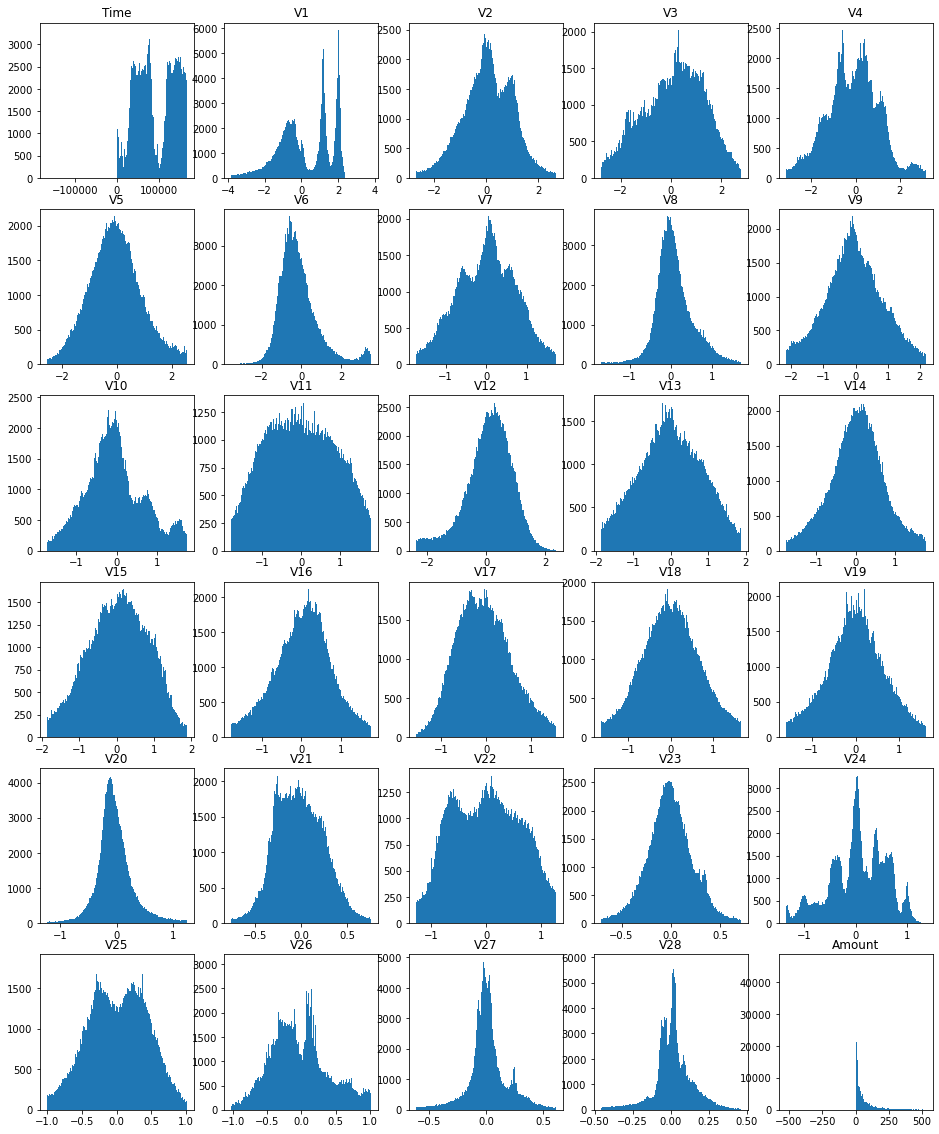

In [25]:
%%time
n_rows, n_cols = (6, 5)
plt.figure(figsize=(16, 20))
for i in range(n_rows):
    for j in range(n_cols):
        k = j + n_cols*i
        plt.subplot(n_rows, n_cols, 1 + k)
        plt.title(df.columns[k])
        a = np.abs(np.percentile(X_train[:,k], [3, 97])).max()
        plt.hist(X_train[:,k], 200, [-a, a]);

In [26]:
# Optional preprocessing

from sklearn.base import BaseEstimator, TransformerMixin
class MyTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X[:, -1] = np.log1p(X[:, -1])
        return X

In [27]:
prep = make_pipeline(MyTransformer(), StandardScaler())
X_train = prep.fit_transform(X_train_orig)
X_val = prep.transform(X_val_orig)

Wall time: 4.67 s


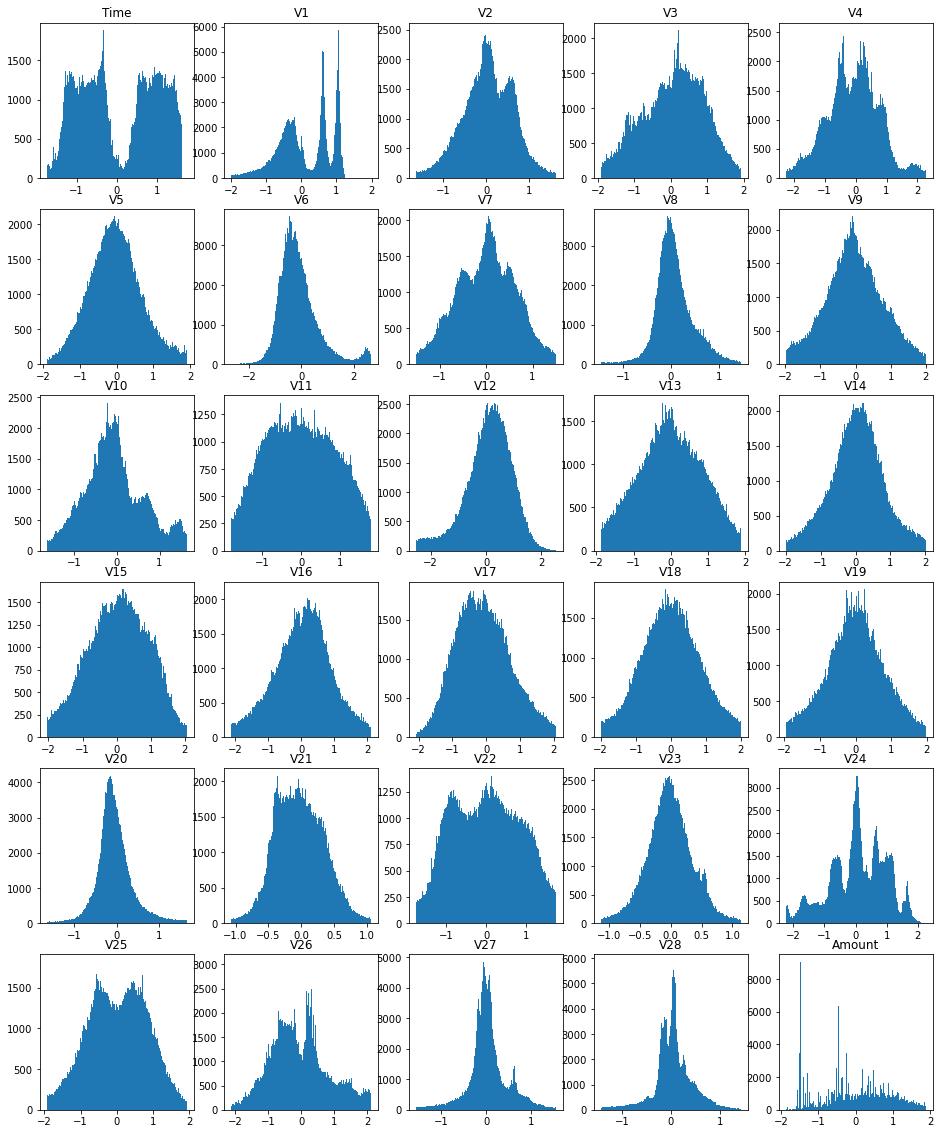

In [28]:
%%time
n_rows, n_cols = (6, 5)
plt.figure(figsize=(16, 20))
for i in range(n_rows):
    for j in range(n_cols):
        k = j + n_cols*i
        plt.subplot(n_rows, n_cols, 1 + k)
        plt.title(df.columns[k])
        a = np.abs(np.percentile(X_train[:,k], [3, 97])).max()
        plt.hist(X_train[:,k], 200, [-a, a]);

## Desempenho de modelos gaussianos

### Average precision e a curva precision-recall

Val AP: 65.33%
Val AUPRC: 65.14%


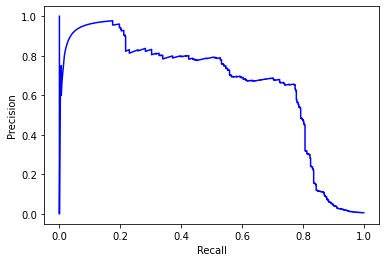

In [29]:
X_train = X_train_orig.copy()
X_val = X_val_orig.copy()

model = EmpiricalCovariance().fit(X_train)
y_score = model.mahalanobis(X_val)
print(f'Val AP: {average_precision_score(y_val, y_score):.2%}')

precision, recall, thresholds = precision_recall_curve(y_val, y_score)
print(f'Val AUPRC: {auc(recall, precision):.2%}')
plt.plot(recall, precision, 'b-');
plt.xlabel('Recall');
plt.ylabel('Precision');

### EmpiricalCovariance

In [30]:
%%time
X_train = X_train_orig.copy()
X_val = X_val_orig.copy()
model = EmpiricalCovariance().fit(X_train)
y_score = model.mahalanobis(X_val)
print(f'Val AP: {average_precision_score(y_val, y_score):.2%}')

Val AP: 65.33%
Wall time: 197 ms


In [31]:
%%time
prep = make_pipeline(StandardScaler())
X_train = prep.fit_transform(X_train_orig)
X_val = prep.transform(X_val_orig)
model = EmpiricalCovariance().fit(X_train)
y_score = model.mahalanobis(X_val)
print(f'Val AP: {average_precision_score(y_val, y_score):.2%}')

Val AP: 65.33%
Wall time: 289 ms


In [32]:
%%time
prep = make_pipeline(MyTransformer())
X_train = prep.fit_transform(X_train_orig)
X_val = prep.transform(X_val_orig)
model = EmpiricalCovariance().fit(X_train)
y_score = model.mahalanobis(X_val)
print(f'Val AP: {average_precision_score(y_val, y_score):.2%}')

Val AP: 66.87%
Wall time: 205 ms


In [33]:
%%time
prep = make_pipeline(MyTransformer(), StandardScaler())
X_train = prep.fit_transform(X_train_orig)
X_val = prep.transform(X_val_orig)
model = EmpiricalCovariance().fit(X_train)
y_score = model.mahalanobis(X_val)
print(f'Val AP: {average_precision_score(y_val, y_score):.2%}')

Val AP: 66.87%
Wall time: 342 ms


### MivCovDet

In [34]:
%%time
X_train = X_train_orig.copy()
X_val = X_val_orig.copy()
model = MinCovDet(support_fraction=1).fit(X_train)
y_score = model.mahalanobis(X_val)
print(f'Val AP: {average_precision_score(y_val, y_score):.2%}')

Val AP: 5.09%
Wall time: 34.5 s


In [35]:
%%time
prep = make_pipeline(StandardScaler())
X_train = prep.fit_transform(X_train_orig)
X_val = prep.transform(X_val_orig)
model = MinCovDet(support_fraction=1).fit(X_train)
y_score = model.mahalanobis(X_val)
print(f'Val AP: {average_precision_score(y_val, y_score):.2%}')

Val AP: 76.95%
Wall time: 36.2 s


In [36]:
%%time
prep = make_pipeline(MyTransformer(), StandardScaler())
X_train = prep.fit_transform(X_train_orig)
X_val = prep.transform(X_val_orig)
model = MinCovDet(support_fraction=1).fit(X_train)
y_score = model.mahalanobis(X_val)
print(f'Val AP: {average_precision_score(y_val, y_score):.2%}')

Val AP: 77.01%
Wall time: 34.8 s


In [37]:
len(X_train)

189543

In [38]:
%%time
prep = make_pipeline(MyTransformer(), StandardScaler())
X_train = prep.fit_transform(X_train_orig)
X_val = prep.transform(X_val_orig)
N = 4000
model = MinCovDet(support_fraction=1).fit(X_train[:N])
y_score = model.mahalanobis(X_val)
print(f'Val AP: {average_precision_score(y_val, y_score):.2%}')

Val AP: 77.00%
Wall time: 1.91 s


In [39]:
average_precision_score(np.r_[y_val, np.zeros(len(X_train[N:]))], model.mahalanobis(np.r_[X_val, X_train[N:]]))

0.7140868915230149

- Uma limitação das métricas derivadas da *precision* é que variam com a **prevalência** (proporção de amostras positivas) no conjunto de validação/teste; portanto, a prevalência não deve ser alterada;
- Para evitar essa dependência, o uso de *precision* e qualquer métrica derivada (como *average precision* e o score f1) deve ser evitado.

### Curva ROC e métricas associadas

Val AUC-ROC: 95.82%
Val AUROC: 95.82%


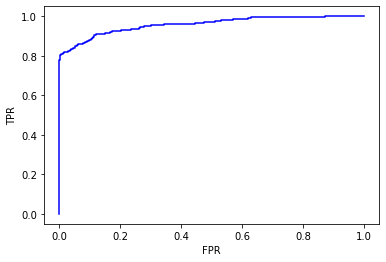

In [40]:
print(f'Val AUC-ROC: {roc_auc_score(y_val, y_score):.2%}')
fpr, tpr, thresholds = roc_curve(y_val, y_score)
print(f'Val AUROC: {auc(fpr, tpr):.2%}')
plt.plot(fpr, tpr, 'b-');
plt.xlabel('FPR');
plt.ylabel('TPR');

In [41]:
roc_auc_score(np.r_[y_val, np.zeros(len(X_train[N:]))], model.mahalanobis(np.r_[X_val, X_train[N:]]))

0.958242607148259

In [42]:
fpr_target = 1e-3

In [43]:
i = np.where(fpr < fpr_target)[0][-1]
fpr[i], tpr[i]

(0.0003482041109188368, 0.8008130081300813)

In [44]:
def tpr_at_fpr(y_true, y_score, fpr_target=1e-3):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    i = np.where(fpr < fpr_target)[0][-1]
    return tpr[i]

In [45]:
tpr = tpr_at_fpr(y_val, y_score, fpr_target)
print(f'Val TPR: {tpr:.2%}')

Val TPR: 80.08%


In [46]:
tpr_at_fpr(np.r_[y_val, np.zeros(len(X_train[N:]))], model.mahalanobis(np.r_[X_val, X_train[N:]]))

0.8008130081300813

- A métrica TPR@FPR não varia com a prevalência